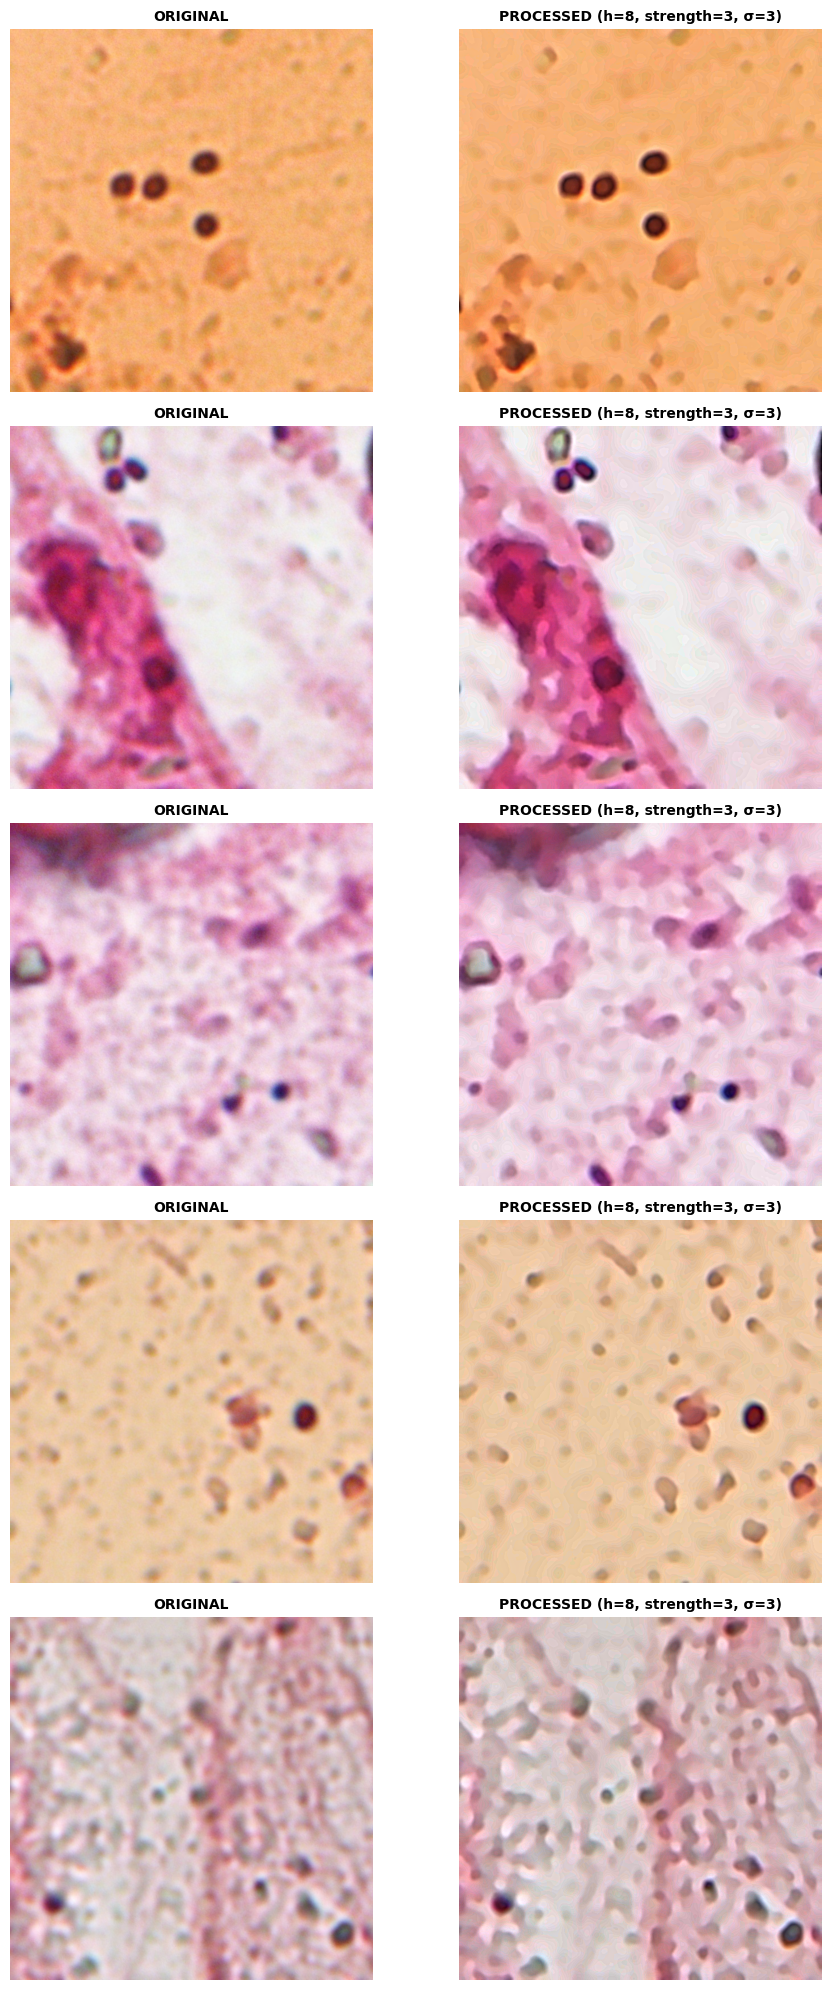

In [11]:
import os, cv2, numpy as np, matplotlib.pyplot as plt

ROOT = "/Users/karyna/Documents/Alternative TA/Final"
SPLIT = "train"
IMAGE_LIST = ["000013_3_5.jpg", "902894.jpg", "902884.jpg", "902512.jpg", "000078_6_3.jpg"]

def imread_color(p):
    img = cv2.imread(p, cv2.IMREAD_COLOR)
    if img is None:
        raise FileNotFoundError(p)
    return img

def sharpen_image(image, strength=2.0, sigma=2.0):
    img_float = image.astype(np.float32)
    gaussian = cv2.GaussianBlur(img_float, (0, 0), sigma)
    sharpened = img_float + strength * (img_float - gaussian)
    sharpened = np.clip(sharpened, 0, 255).astype(np.uint8)
    return sharpened

def denoise_image(image, h=10, h_color=10, template_size=7, search_size=21):
    return cv2.fastNlMeansDenoisingColored(image, None, h, h_color, 
                                           template_size, search_size)

def preprocess_bacteria_image(image, denoise=True, sharpen=True,
                              denoise_h=8, sharpen_strength=2.0, sharpen_sigma=2.0):
    result = image.copy()
    
    if denoise:
        result = denoise_image(result, h=denoise_h)
    
    if sharpen:
        result = sharpen_image(result, strength=sharpen_strength, sigma=sharpen_sigma)
    
    return result

def compare_parameters(image_path, denoise_h_values=[6, 8, 10, 12], 
                      sharpen_strengths=[1.5, 2.0, 2.5, 3.0]):
    """
    Visualize different parameter combinations to find optimal settings
    """
    img = imread_color(image_path)
    
    fig, axes = plt.subplots(len(denoise_h_values), len(sharpen_strengths) + 1, 
                            figsize=(16, 4*len(denoise_h_values)))
    
    for i, h in enumerate(denoise_h_values):
        axes[i, 0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        axes[i, 0].set_title(f"ORIGINAL", fontsize=9, fontweight='bold')
        axes[i, 0].axis("off")
        
        for j, strength in enumerate(sharpen_strengths):
            processed = preprocess_bacteria_image(img, denoise=True, sharpen=True,
                                                 denoise_h=h, 
                                                 sharpen_strength=strength)
            
            axes[i, j+1].imshow(cv2.cvtColor(processed, cv2.COLOR_BGR2RGB))
            axes[i, j+1].set_title(f"h={h}, strength={strength}", 
                                  fontsize=9, fontweight='bold')
            axes[i, j+1].axis("off")
    
    plt.tight_layout()
    plt.show()

# ============== MAIN PROCESSING ==============
# Collect images
img_paths = []
for name in IMAGE_LIST:
    p = name if os.path.isabs(name) else os.path.join(ROOT, "images", SPLIT, name)
    if os.path.exists(p): 
        img_paths.append(p)
    else: 
        print(f"[WARN] Not found: {p}")

if not img_paths: 
    raise SystemExit("No valid images.")

# Preview with your preferred settings
rows = len(img_paths)
plt.figure(figsize=(10, 4*rows))

# YOUR OPTIMIZED SETTINGS - ADJUST THESE!
DENOISE_H = 8           # Try: 6, 8, 10, 12
SHARPEN_STRENGTH = 3  # Try: 1.5, 2.0, 2.5, 3.0
SHARPEN_SIGMA = 3     # Try: 1.5, 2.0, 2.5, 3.0

for idx, p in enumerate(img_paths, 1):
    original = imread_color(p)
    processed = preprocess_bacteria_image(original, 
                                         denoise=True, 
                                         sharpen=True,
                                         denoise_h=DENOISE_H,
                                         sharpen_strength=SHARPEN_STRENGTH,
                                         sharpen_sigma=SHARPEN_SIGMA)
    
    ax1 = plt.subplot(rows, 2, 2*idx-1)
    ax1.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
    ax1.set_title("ORIGINAL", fontsize=10, fontweight='bold')
    ax1.axis("off")
    
    ax2 = plt.subplot(rows, 2, 2*idx)
    ax2.imshow(cv2.cvtColor(processed, cv2.COLOR_BGR2RGB))
    ax2.set_title(f"PROCESSED (h={DENOISE_H}, strength={SHARPEN_STRENGTH}, σ={SHARPEN_SIGMA})", 
                 fontsize=10, fontweight='bold')
    ax2.axis("off")

plt.tight_layout()
plt.show()
# compare_parameters(img_paths[2])

In [14]:
def batch_preprocess_and_save(denoise_h=8, sharpen_strength=2.0, sharpen_sigma=2.0):
    """
    Process all train/val/test images and save to new folders
    Mirrors the label structure automatically
    """
    import glob, shutil
    from tqdm import tqdm
    
    # Paths
    IMAGES_IN  = os.path.join(ROOT, "images")
    LABELS_IN  = os.path.join(ROOT, "labels")
    IMAGES_OUT = os.path.join(ROOT, "images_preprocessed")
    LABELS_OUT = os.path.join(ROOT, "labels_preprocessed")
    
    assert os.path.isdir(IMAGES_IN), f"Missing folder: {IMAGES_IN}"
    assert os.path.isdir(LABELS_IN), f"Missing folder: {LABELS_IN}"
    
    print("\n" + "="*60)
    print("📊 SCANNING DATASET...")
    print("="*60)
    
    splits_info = {}
    for split in ["train", "val", "test"]:
        in_dir = os.path.join(IMAGES_IN, split)
        
        if not os.path.isdir(in_dir):
            continue
        
        # Count images
        img_paths = []
        for ext in (".jpg", ".jpeg", ".png", ".bmp"):
            img_paths += glob.glob(os.path.join(in_dir, f"**/*{ext}"), recursive=True)
        
        if img_paths:
            splits_info[split] = img_paths
            print(f"  ✓ {split.upper():5s}: {len(img_paths):,} images found")
    
    if not splits_info:
        print("\n❌ ERROR: No train/val/test folders found or no images inside!")
        return
    
    print("="*60)
    print(f"📦 Total images to process: {sum(len(paths) for paths in splits_info.values()):,}")
    print(f"⚙️  Settings: h={denoise_h}, strength={sharpen_strength}, σ={sharpen_sigma}")
    print("="*60 + "\n")
    
    # Confirm before processing
    response = input("Continue with preprocessing? (y/n): ").strip().lower()
    if response != 'y':
        print("❌ Cancelled.")
        return
    
    os.makedirs(IMAGES_OUT, exist_ok=True)
    os.makedirs(LABELS_OUT, exist_ok=True)
    
    def save_img(path, img):
        """Save with appropriate quality settings"""
        ext = os.path.splitext(path)[1].lower()
        if ext in (".jpg", ".jpeg"):
            cv2.imwrite(path, img, [int(cv2.IMWRITE_JPEG_QUALITY), 95])
        elif ext in (".png",):
            cv2.imwrite(path, img, [int(cv2.IMWRITE_PNG_COMPRESSION), 3])
        else:
            cv2.imwrite(path, img)
    
    total_written = 0
    
    # ============== PROCESS EACH SPLIT ==============
    for split, img_paths in splits_info.items():
        print(f"\n{'='*60}")
        print(f"Processing {split.upper()}...")
        print(f"{'='*60}")
        
        in_dir  = os.path.join(IMAGES_IN, split)
        out_dir = os.path.join(IMAGES_OUT, split)
        os.makedirs(out_dir, exist_ok=True)
        
        # Process with progress bar
        for src in tqdm(img_paths, desc=f"{split.upper()}", unit="img"):
            rel = os.path.relpath(src, in_dir)
            dst = os.path.join(out_dir, rel)
            os.makedirs(os.path.dirname(dst), exist_ok=True)
            
            img = cv2.imread(src, cv2.IMREAD_COLOR)
            if img is None:
                tqdm.write(f"[WARN] Unreadable, skip: {src}")
                continue
            
            # Apply preprocessing pipeline
            processed = preprocess_bacteria_image(img,
                                                 denoise=True,
                                                 sharpen=True,
                                                 denoise_h=denoise_h,
                                                 sharpen_strength=sharpen_strength,
                                                 sharpen_sigma=sharpen_sigma)
            
            save_img(dst, processed)
            total_written += 1
        
        print(f"Done.\n")
        
        in_labels  = os.path.join(LABELS_IN, split)
        out_labels = os.path.join(LABELS_OUT, split)
        if os.path.isdir(in_labels):
            label_files = glob.glob(os.path.join(in_labels, "**/*.txt"), recursive=True)
            for lbl in tqdm(label_files, desc=f"{split.upper()} labels", unit="file"):
                rel = os.path.relpath(lbl, in_labels)
                dst = os.path.join(out_labels, rel)
                os.makedirs(os.path.dirname(dst), exist_ok=True)
                shutil.copy2(lbl, dst)
            print(f"Done.\n")
    
    print(f"\n{'='*60}")
    print(f"🎉 COMPLETE! Processed {total_written:,} images")
    print(f"   Settings: h={denoise_h}, strength={sharpen_strength}, σ={sharpen_sigma}")
    print(f"\n📁 Output folders:")
    print(f"   Images: {IMAGES_OUT}")
    print(f"   Labels: {LABELS_OUT}")
    print(f"\n💡 Update your YAML to point to these new folders!")
    print(f"{'='*60}")

batch_preprocess_and_save(denoise_h=DENOISE_H, sharpen_strength=SHARPEN_STRENGTH, sharpen_sigma=SHARPEN_SIGMA)


📊 SCANNING DATASET...
  ✓ TRAIN: 3,446 images found
  ✓ VAL  : 1,376 images found
  ✓ TEST : 695 images found
📦 Total images to process: 5,517
⚙️  Settings: h=8, strength=3, σ=3


Processing TRAIN...


TRAIN: 100%|██████████| 3446/3446 [07:39<00:00,  7.50img/s]


Done.



TRAIN labels: 100%|██████████| 3446/3446 [00:00<00:00, 3834.12file/s]


Done.


Processing VAL...


VAL: 100%|██████████| 1376/1376 [03:04<00:00,  7.47img/s]


Done.



VAL labels: 100%|██████████| 1376/1376 [00:00<00:00, 4095.09file/s]


Done.


Processing TEST...


TEST: 100%|██████████| 695/695 [01:34<00:00,  7.39img/s]


Done.



TEST labels: 100%|██████████| 695/695 [00:00<00:00, 5053.90file/s]

Done.


🎉 COMPLETE! Processed 5,517 images
   Settings: h=8, strength=3, σ=3

📁 Output folders:
   Images: /Users/karyna/Documents/Alternative TA/Final/images_preprocessed
   Labels: /Users/karyna/Documents/Alternative TA/Final/labels_preprocessed

💡 Update your YAML to point to these new folders!


In [ ]:
import os, glob, shutil, random

"""
Current split:
- TRAIN: 3,446 (62.5%)
- VAL:   1,376 (25.0%)
- TEST:   695 (12.5%)

Recommended split for object detection:
- TRAIN: 70-80%  → ~3,900-4,400 images
- VAL:   10-20%  → ~550-1,100 images
- TEST:  10%     → ~550 images (keep as is)
"""

def move_random_images(n_images=412, source_split="val", target_split="train", 
                       dry_run=True):
    # Paths
    images_root = os.path.join(ROOT, "images_preprocessed")
    labels_root = os.path.join(ROOT, "labels_preprocessed")
    
    src_img_dir = os.path.join(images_root, source_split)
    dst_img_dir = os.path.join(images_root, target_split)
    src_lbl_dir = os.path.join(labels_root, source_split)
    dst_lbl_dir = os.path.join(labels_root, target_split)
    
    assert os.path.isdir(src_img_dir), f"Source not found: {src_img_dir}"
    assert os.path.isdir(dst_img_dir), f"Target not found: {dst_img_dir}"
    
    img_paths = []
    for ext in (".jpg", ".jpeg", ".png", ".bmp"):
        img_paths += glob.glob(os.path.join(src_img_dir, f"**/*{ext}"), recursive=True)
    
    print(f"\n{'='*60}")
    print(f"📊 DATASET REBALANCING")
    print(f"{'='*60}")
    print(f"Source ({source_split.upper()}): {len(img_paths)} images")
    print(f"Requested move: {n_images} images")
    
    if n_images > len(img_paths):
        print(f"\n❌ ERROR: Cannot move {n_images} images, only {len(img_paths)} available!")
        return
    
    if n_images >= len(img_paths) * 0.9:
        print(f"\n⚠️  WARNING: Moving {n_images}/{len(img_paths)} ({n_images/len(img_paths)*100:.1f}%) of images!")
        print(f"   This will leave very few images in {source_split.upper()}.")
    
    random.seed(42)  # For reproducibility
    selected_imgs = random.sample(img_paths, n_images)
    
    # print(f"\n{'='*60}")
    # print(f"SELECTED {len(selected_imgs)} RANDOM IMAGES")
    # print(f"{'='*60}")
    
    # # Preview first 5
    # print("\nPreview (first 5):")
    # for i, img in enumerate(selected_imgs[:5], 1):
    #     print(f"  {i}. {os.path.basename(img)}")
    # if len(selected_imgs) > 5:
    #     print(f"  ... and {len(selected_imgs) - 5} more")
    
    # Calculate new split
    remaining = len(img_paths) - n_images
    total = 3446 + 1376 + 695  # Your original total
    new_train = 3446 + n_images
    new_val = remaining
    
    print(f"\n{'='*60}")
    print(f"NEW DATASET SPLIT (after move)")
    print(f"{'='*60}")
    print(f"TRAIN: {new_train:,} ({new_train/total*100:.1f}%)")
    print(f"VAL:   {new_val:,} ({new_val/total*100:.1f}%)")
    print(f"TEST:  695 (12.5%)")
    print(f"{'='*60}")
    
    if dry_run:
        print(f"\n🔍 DRY RUN MODE - No files will be moved")
        print(f"   Set dry_run=False to actually move files")
        return selected_imgs
    
    # Confirm before moving
    print(f"\n⚠️  This will MOVE {n_images} images from {source_split} to {target_split}")
    response = input("Continue? (y/n): ").strip().lower()
    if response != 'y':
        print("❌ Cancelled.")
        return
    
    # Move images and labels
    moved_count = 0
    missing_labels = []
    
    print(f"\n{'='*60}")
    print(f"MOVING FILES...")
    print(f"{'='*60}\n")
    
    from tqdm import tqdm
    
    for img_path in tqdm(selected_imgs, desc="Moving", unit="file"):
        # Image paths
        rel_path = os.path.relpath(img_path, src_img_dir)
        dst_img_path = os.path.join(dst_img_dir, rel_path)
        os.makedirs(os.path.dirname(dst_img_path), exist_ok=True)
        
        # Label paths
        base_name = os.path.splitext(os.path.basename(img_path))[0]
        src_lbl_path = os.path.join(src_lbl_dir, os.path.dirname(rel_path), f"{base_name}.txt")
        dst_lbl_path = os.path.join(dst_lbl_dir, os.path.dirname(rel_path), f"{base_name}.txt")
        
        # Move image
        shutil.move(img_path, dst_img_path)
        
        # Move label if exists
        if os.path.exists(src_lbl_path):
            os.makedirs(os.path.dirname(dst_lbl_path), exist_ok=True)
            shutil.move(src_lbl_path, dst_lbl_path)
        else:
            missing_labels.append(base_name)
        
        moved_count += 1
    
    print(f"Done.\n")
    
    # Summary
    print(f"{'='*60}")
    print(f"✅ SUCCESS!")
    print(f"{'='*60}")
    # print(f"Moved: {moved_count} images")
    
    if missing_labels:
        print(f"\n⚠️  {len(missing_labels)} images had no matching labels:")
        for name in missing_labels[:5]:
            print(f"   - {name}")
        if len(missing_labels) > 5:
            print(f"   ... and {len(missing_labels) - 5} more")
    
    print(f"\n💡 Verify the new split:")
    print(f"   python check_dataset.py  # or re-run your scanning code")
    print(f"{'='*60}")
    
    return moved_count

# print("🔍 PERFORMING DRY RUN...")
move_random_images(n_images=275, source_split="val", target_split="train", dry_run=False)

# TOTAL MOVED IS 412 + 275


📊 DATASET REBALANCING
Source (VAL): 964 images
Requested move: 275 images

NEW DATASET SPLIT (after move)
TRAIN: 3,721 (67.4%)
VAL:   689 (12.5%)
TEST:  695 (12.5%)

⚠️  This will MOVE 275 images from val to train

MOVING FILES...



Moving: 100%|██████████| 275/275 [00:00<00:00, 1753.30file/s]

Done.

✅ SUCCESS!

💡 Verify the new split:
   python check_dataset.py  # or re-run your scanning code


275

,images_total,images_with_labels,images_missing_labels
split,,,
train,"3,593","3,593",0
val,689,689,0
test,695,695,0


,instances
class,
negative_cocci,"1,809"
positive_cocci,806
negative_bacilli,"3,294"
positive_bacilli,559


,instances
class,
negative_cocci,378
positive_cocci,148
negative_bacilli,598
positive_bacilli,113


,instances
class,
negative_cocci,338
positive_cocci,161
negative_bacilli,630
positive_bacilli,105



Total instances across splits: 8939


,instances,share_%
class,,
negative_cocci,"2,525",28.25
positive_cocci,"1,115",12.47
negative_bacilli,"4,522",50.59
positive_bacilli,777,8.69


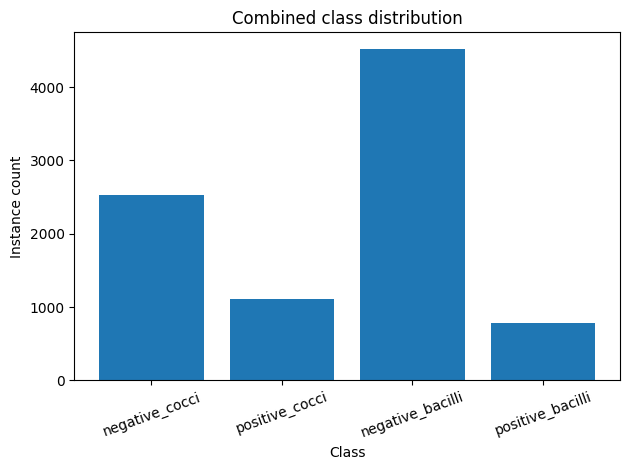

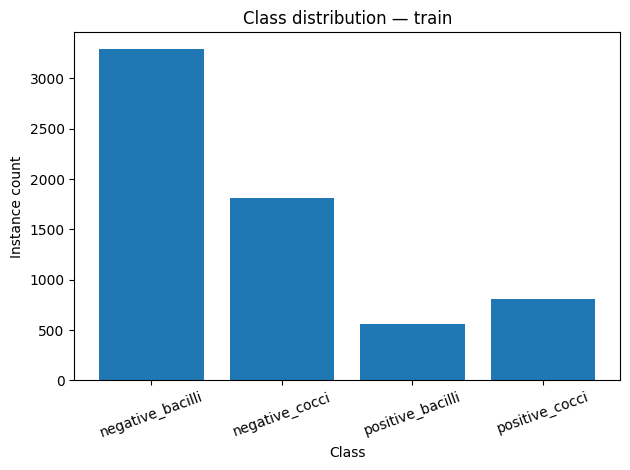

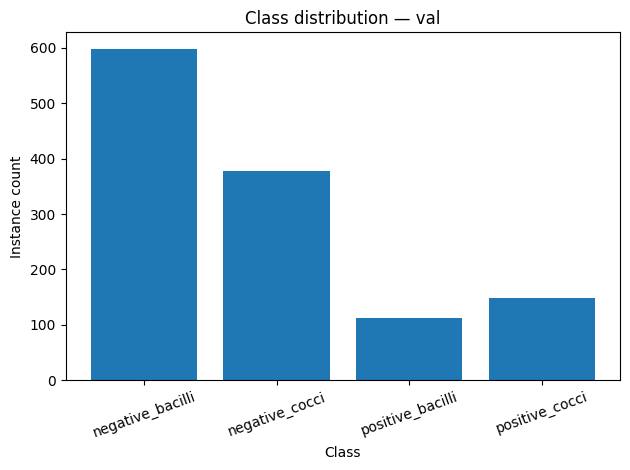

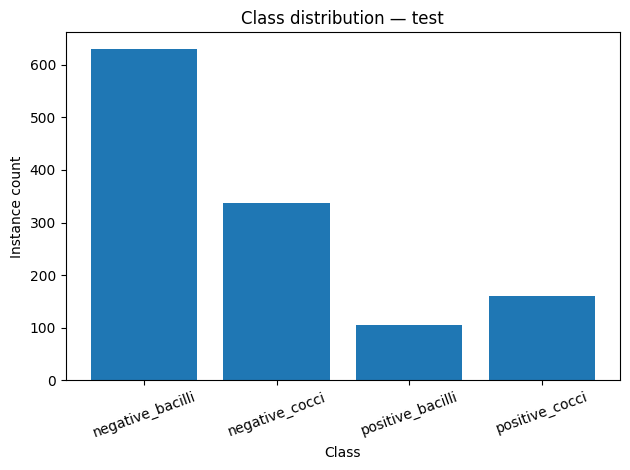


Suggested augmentation multipliers (to roughly match the largest TRAIN class):
 - negative_bacilli: ×1.0 (target ~3294, current 3294)
 - negative_cocci: ×1.8 (target ~3294, current 1809)
 - positive_bacilli: ×5.9 (target ~3294, current 559)
 - positive_cocci: ×4.1 (target ~3294, current 806)


In [42]:
import os
from pathlib import Path
from collections import Counter
import yaml
import pandas as pd
import matplotlib.pyplot as plt

data_yaml_path = Path("/Users/karyna/Documents/Alternative TA/Final/data.yaml")

# (Optional) If your labels are NOT in the standard mirrored location,
# you can force them like this (comment out to disable):
force_labels_dir = {
    # "train": Path("/path/to/labels/train"),
    # "val":   Path("/path/to/labels/val"),
    # "test":  Path("/path/to/labels/test"),
}

# ======= Helpers =======
IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff", ".webp"}

def derive_labels_dir(images_dir: Path) -> Path:
    parts = list(images_dir.parts)
    if "images" in parts:
        i = parts.index("images")
        parts[i] = "labels"
        return Path(*parts)
    # fallback: assume sibling "labels" under same parent
    return images_dir.parent / "labels" / images_dir.name

def yolo_label_for_image(img_path: Path, labels_dir: Path) -> Path:
    return labels_dir / (img_path.stem + ".txt")

def gather_images(images_dir: Path):
    if not images_dir.exists():
        return []
    return sorted([p for p in images_dir.rglob("*") if p.suffix.lower() in IMG_EXTS])

def parse_label_file(label_path: Path):
    objs = []
    try:
        with open(label_path, "r") as f:
            for line in f:
                line = line.strip()
                if not line:
                    continue
                parts = line.split()
                try:
                    cls = int(parts[0])
                    # YOLO: cls cx cy w h (normalized) — we only need cls
                    objs.append(cls)
                except Exception:
                    # skip malformed lines
                    continue
    except FileNotFoundError:
        pass
    return objs

# ======= Load YAML =======
with open(data_yaml_path, "r") as f:
    data_yaml = yaml.safe_load(f)

splits = {}
for split in ["train", "val", "test"]:
    if data_yaml.get(split):
        splits[split] = Path(data_yaml[split])

names = data_yaml.get("names", [])
if isinstance(names, dict):
    names = [names[k] for k in sorted(names.keys(), key=lambda x: int(x))]
class_names = list(names)
nc = int(data_yaml.get("nc", len(class_names)))
if len(class_names) != nc:
    print(f"[WARN] nc ({nc}) != len(names) ({len(class_names)}); using names list length.")

# ======= Analyze per split =======
summaries = []
per_split_class_counts = {}
for split, images_dir in splits.items():
    images_dir = images_dir.expanduser()
    labels_dir = None

    # allow override
    if 'force_labels_dir' in globals() and force_labels_dir and split in force_labels_dir:
        labels_dir = Path(force_labels_dir[split]).expanduser()
    else:
        labels_dir = derive_labels_dir(images_dir)

    imgs = gather_images(images_dir)
    img_count = len(imgs)

    label_file_count = 0
    missing_labels = 0
    instances = Counter()

    for img in imgs:
        lbl = yolo_label_for_image(img, labels_dir)
        if not lbl.exists():
            missing_labels += 1
            continue
        label_file_count += 1
        objs = parse_label_file(lbl)
        for cls_id in objs:
            instances[cls_id] += 1

    # map to class names
    named_counts = { (class_names[cid] if cid < len(class_names) else f"class_{cid}"): cnt
                     for cid, cnt in sorted(instances.items()) }
    # ensure all classes appear
    for cname in class_names:
        named_counts.setdefault(cname, 0)

    summaries.append({
        "split": split,
        "images_total": img_count,
        "images_with_labels": label_file_count,
        "images_missing_labels": missing_labels
    })
    per_split_class_counts[split] = named_counts

# ======= Display tables =======
summary_df = pd.DataFrame(summaries).set_index("split")
display(summary_df.style.format(thousands=","))

class_tables = {}
for split, counts in per_split_class_counts.items():
    df = pd.DataFrame.from_dict(counts, orient="index", columns=["instances"]).rename_axis("class")
    class_tables[split] = df.sort_index()
    display(df.style.format(thousands=","))

# ======= Combined distribution =======
combined = Counter()
for split, counts in per_split_class_counts.items():
    combined.update(counts)

combined_df = pd.DataFrame.from_dict(combined, orient="index", columns=["instances"]).rename_axis("class")
combined_df = combined_df.reindex(class_names)  # keep original order
total_instances = combined_df["instances"].sum()
combined_df["share_%"] = (combined_df["instances"] / total_instances * 100.0) if total_instances > 0 else 0.0

print("\nTotal instances across splits:", int(total_instances))
display(combined_df.style.format({"instances": "{:,}", "share_%": "{:.2f}"}))

# ======= Charts (matplotlib, one plot per figure, no colors) =======
# Combined
plt.figure()
plt.bar(combined_df.index.tolist(), combined_df["instances"].tolist())
plt.title("Combined class distribution")
plt.xlabel("Class")
plt.ylabel("Instance count")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

# Per split
for split, df in class_tables.items():
    plt.figure()
    plt.bar(df.index.tolist(), df["instances"].tolist())
    plt.title(f"Class distribution — {split}")
    plt.xlabel("Class")
    plt.ylabel("Instance count")
    plt.xticks(rotation=20)
    plt.tight_layout()
    plt.show()

if "train" in class_tables:
    train_counts = class_tables["train"]["instances"]
    max_train = int(train_counts.max()) if not train_counts.empty else 0
    if max_train > 0:
        print("\nSuggested augmentation multipliers (to roughly match the largest TRAIN class):")
        for cname, cnt in train_counts.items():
            mult = (max_train / cnt) if cnt > 0 else float("inf")
            # Round to 1 decimal; cap very large to 'x≥N'
            if mult == float("inf"):
                msg = f"{cname}: add many (no instances found)"
            else:
                msg = f"{cname}: ×{mult:.1f} (target ~{max_train}, current {int(cnt)})"
            print(" -", msg)


In [43]:
import os
from pathlib import Path
import yaml
from collections import Counter

# ===== Load YAML =====
with open(data_yaml_path, "r") as f:
    data = yaml.safe_load(f)

splits = {s: Path(data[s]).expanduser() for s in ["train", "val", "test"] if s in data}
names = data["names"]
if isinstance(names, dict):  # YOLO sometimes uses dict
    names = [names[k] for k in sorted(names.keys(), key=lambda x: int(x))]

def derive_labels_dir(images_dir: Path) -> Path:
    parts = list(images_dir.parts)
    if "images" in parts:
        i = parts.index("images")
        parts[i] = "labels"
        return Path(*parts)
    return images_dir.parent / "labels" / images_dir.name

def gather_images(images_dir: Path):
    exts = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff", ".webp"}
    return [p for p in images_dir.rglob("*") if p.suffix.lower() in exts]

def yolo_label_for_image(img_path: Path, labels_dir: Path) -> Path:
    return labels_dir / (img_path.stem + ".txt")

def parse_label_file(label_path: Path):
    objs = []
    try:
        with open(label_path, "r") as f:
            for line in f:
                if not line.strip():
                    continue
                parts = line.strip().split()
                try:
                    cls = int(parts[0])
                    objs.append(cls)
                except:
                    pass
    except FileNotFoundError:
        pass
    return objs

# ===== Analyze =====
for split, images_dir in splits.items():
    labels_dir = derive_labels_dir(images_dir)
    images = gather_images(images_dir)

    class_counts = Counter()
    missing_labels = 0
    for img in images:
        lbl = yolo_label_for_image(img, labels_dir)
        objs = parse_label_file(lbl)
        if not objs:
            missing_labels += 1
        for cls in objs:
            class_counts[cls] += 1

    print(f"\n=== {split.upper()} ===")
    print(f"Total images: {len(images)}")
    print(f"Images missing labels: {missing_labels}")
    for i, cname in enumerate(names):
        print(f"  {cname:15s}: {class_counts[i]}")
    total = sum(class_counts.values())
    print(f"Total instances: {total}")


=== TRAIN ===
Total images: 3593
Images missing labels: 0
  negative_cocci : 1809
  positive_cocci : 806
  negative_bacilli: 3294
  positive_bacilli: 559
Total instances: 6468

=== VAL ===
Total images: 689
Images missing labels: 0
  negative_cocci : 378
  positive_cocci : 148
  negative_bacilli: 598
  positive_bacilli: 113
Total instances: 1237

=== TEST ===
Total images: 695
Images missing labels: 0
  negative_cocci : 338
  positive_cocci : 161
  negative_bacilli: 630
  positive_bacilli: 105
Total instances: 1234


In [44]:
import os
import cv2
import numpy as np
import random
from pathlib import Path
from collections import Counter
import shutil
from typing import List, Dict, Tuple
from tqdm import tqdm

# ===== CONFIG =====
ROOT = Path("/Users/karyna/Documents/Alternative TA/Final")
IMAGES_DIR = ROOT / "images"
LABELS_DIR = ROOT / "labels" 
OUTPUT_IMAGES = ROOT / "images_balanced"
OUTPUT_LABELS = ROOT / "labels_balanced"

# Class names
CLASS_NAMES = ["negative_cocci", "positive_cocci", "negative_bacilli", "positive_bacilli"]

# NEW AUGMENTATION MULTIPLIERS (based on analysis)
# Target: Match negative_bacilli (~3294 images)
AUGMENTATION_MULTIPLIERS = {
    0: 1.8,  # negative_cocci: 1809 → ~3294
    1: 4.1,  # positive_cocci: 806 → ~3294
    2: 1.0,  # negative_bacilli: 3294 (baseline, no aug needed)
    3: 5.9   # positive_bacilli: 559 → ~3294
}

def gather_images_with_classes(images_dir: Path, labels_dir: Path, split: str) -> Dict[int, List[Path]]:
    """Group images by their primary class"""
    class_to_images = {i: [] for i in range(len(CLASS_NAMES))}
    
    images_split_dir = images_dir / split
    labels_split_dir = labels_dir / split
    
    if not images_split_dir.exists():
        print(f"Warning: {images_split_dir} doesn't exist")
        return class_to_images
    
    # Get all images
    exts = {".jpg", ".jpeg", ".png", ".bmp"}
    for img_path in images_split_dir.rglob("*"):
        if img_path.suffix.lower() in exts:
            # Find corresponding label
            rel_path = img_path.relative_to(images_split_dir)
            label_path = labels_split_dir / rel_path.with_suffix('.txt')
            
            if label_path.exists():
                # Parse label file to get classes
                classes = parse_label_file(label_path)
                if classes:
                    # Use the first/primary class for grouping
                    primary_class = classes[0]
                    class_to_images[primary_class].append(img_path)
    
    return class_to_images

def parse_label_file(label_path: Path) -> List[int]:
    """Parse YOLO label file and return list of class IDs"""
    classes = []
    try:
        with open(label_path, 'r') as f:
            for line in f:
                if line.strip():
                    parts = line.strip().split()
                    if parts:
                        classes.append(int(parts[0]))
    except:
        pass
    return classes

def augment_image(image: np.ndarray, augmentation_type: str) -> np.ndarray:
    """Apply different augmentation techniques"""
    h, w = image.shape[:2]
    
    if augmentation_type == 'rotate_90':
        return cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
    elif augmentation_type == 'rotate_180':
        return cv2.rotate(image, cv2.ROTATE_180)
    elif augmentation_type == 'rotate_270':
        return cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
    elif augmentation_type == 'flip_h':
        return cv2.flip(image, 1)
    elif augmentation_type == 'flip_v':
        return cv2.flip(image, 0)
    elif augmentation_type == 'brightness_up':
        hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        hsv[:,:,2] = np.clip(hsv[:,:,2].astype(int) + 20, 0, 255).astype(np.uint8)
        return cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    elif augmentation_type == 'brightness_down':
        hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        hsv[:,:,2] = np.clip(hsv[:,:,2].astype(int) - 20, 0, 255).astype(np.uint8)
        return cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    elif augmentation_type == 'contrast_up':
        return cv2.convertScaleAbs(image, alpha=1.2, beta=0)
    elif augmentation_type == 'contrast_down':
        return cv2.convertScaleAbs(image, alpha=0.8, beta=0)
    elif augmentation_type == 'rotate_15':
        center = (w//2, h//2)
        matrix = cv2.getRotationMatrix2D(center, 15, 1.0)
        return cv2.warpAffine(image, matrix, (w, h), borderMode=cv2.BORDER_REFLECT)
    elif augmentation_type == 'rotate_-15':
        center = (w//2, h//2)
        matrix = cv2.getRotationMatrix2D(center, -15, 1.0)
        return cv2.warpAffine(image, matrix, (w, h), borderMode=cv2.BORDER_REFLECT)
    elif augmentation_type == 'rotate_30':
        center = (w//2, h//2)
        matrix = cv2.getRotationMatrix2D(center, 30, 1.0)
        return cv2.warpAffine(image, matrix, (w, h), borderMode=cv2.BORDER_REFLECT)
    elif augmentation_type == 'rotate_-30':
        center = (w//2, h//2)
        matrix = cv2.getRotationMatrix2D(center, -30, 1.0)
        return cv2.warpAffine(image, matrix, (w, h), borderMode=cv2.BORDER_REFLECT)
    
    return image

def augment_label(label_content: str, augmentation_type: str, img_shape: Tuple[int, int]) -> str:
    """Adjust YOLO labels for augmentation"""
    lines = label_content.strip().split('\n')
    new_lines = []
    
    h, w = img_shape[:2]
    
    for line in lines:
        if not line.strip():
            continue
            
        parts = line.strip().split()
        if len(parts) < 5:
            continue
            
        cls = parts[0]
        x_center, y_center, width, height = map(float, parts[1:5])
        
        if augmentation_type == 'rotate_90':
            new_x = 1.0 - y_center
            new_y = x_center
            new_width = height
            new_height = width
        elif augmentation_type == 'rotate_180':
            new_x = 1.0 - x_center
            new_y = 1.0 - y_center
            new_width = width
            new_height = height
        elif augmentation_type == 'rotate_270':
            new_x = y_center
            new_y = 1.0 - x_center
            new_width = height
            new_height = width
        elif augmentation_type == 'flip_h':
            new_x = 1.0 - x_center
            new_y = y_center
            new_width = width
            new_height = height
        elif augmentation_type == 'flip_v':
            new_x = x_center
            new_y = 1.0 - y_center
            new_width = width
            new_height = height
        else:
            # For brightness, contrast, small rotations - keep same
            new_x, new_y = x_center, y_center
            new_width, new_height = width, height
        
        new_lines.append(f"{cls} {new_x:.6f} {new_y:.6f} {new_width:.6f} {new_height:.6f}")
    
    return '\n'.join(new_lines)

def copy_split_unchanged(split: str):
    """Copy val/test splits unchanged"""
    print(f"\n{'='*60}")
    print(f"Copying {split.upper()} unchanged...")
    print(f"{'='*60}")
    
    src_img_dir = IMAGES_DIR / split
    src_lbl_dir = LABELS_DIR / split
    dst_img_dir = OUTPUT_IMAGES / split
    dst_lbl_dir = OUTPUT_LABELS / split
    
    if not src_img_dir.exists():
        print(f"Warning: {src_img_dir} doesn't exist")
        return
    
    # Create output directories
    dst_img_dir.mkdir(parents=True, exist_ok=True)
    dst_lbl_dir.mkdir(parents=True, exist_ok=True)
    
    # Copy all images
    exts = {".jpg", ".jpeg", ".png", ".bmp"}
    img_paths = [p for p in src_img_dir.rglob("*") if p.suffix.lower() in exts]
    
    for img_path in tqdm(img_paths, desc=f"{split.upper()}", unit="file"):
        # Copy image
        rel_path = img_path.relative_to(src_img_dir)
        dst_img = dst_img_dir / rel_path
        dst_img.parent.mkdir(parents=True, exist_ok=True)
        shutil.copy2(img_path, dst_img)
        
        # Copy corresponding label
        src_label = src_lbl_dir / rel_path.with_suffix('.txt')
        dst_label = dst_lbl_dir / rel_path.with_suffix('.txt')
        
        if src_label.exists():
            dst_label.parent.mkdir(parents=True, exist_ok=True)
            shutil.copy2(src_label, dst_label)
    
    print(f"Done.\n")

def balance_train_only():
    """Balance ONLY the training set using new multipliers"""
    
    # Create output directories
    OUTPUT_IMAGES.mkdir(exist_ok=True)
    OUTPUT_LABELS.mkdir(exist_ok=True)
    
    print("\n" + "="*60)
    print("🎯 DATASET BALANCING WITH NEW MULTIPLIERS")
    print("="*60)
    print("📋 Strategy:")
    print("   - TRAIN: Balance using augmentation multipliers")
    print("   - VAL/TEST: Keep original (no augmentation)")
    print("="*60)
    
    # Available augmentation techniques
    augmentations = [
        'rotate_90', 'rotate_180', 'rotate_270', 
        'flip_h', 'flip_v', 
        'brightness_up', 'brightness_down',
        'contrast_up', 'contrast_down',
        'rotate_15', 'rotate_-15',
        'rotate_30', 'rotate_-30'
    ]
    
    # 1. BALANCE TRAINING SET
    print(f"\n{'='*60}")
    print(f"BALANCING TRAIN SET")
    print(f"{'='*60}")
    
    split = "train"
    (OUTPUT_IMAGES / split).mkdir(exist_ok=True)
    (OUTPUT_LABELS / split).mkdir(exist_ok=True)
    
    # Gather images by class
    class_to_images = gather_images_with_classes(IMAGES_DIR, LABELS_DIR, split)
    
    # Count current distribution
    total_images = sum(len(images) for images in class_to_images.values())
    print("\n📊 Current TRAIN distribution:")
    for cls, images in class_to_images.items():
        mult = AUGMENTATION_MULTIPLIERS[cls]
        target = int(len(images) * mult)
        print(f"  {CLASS_NAMES[cls]:20s}: {len(images):4d} → {target:4d} (×{mult:.1f})")
    
    # Balance each class
    total_processed = 0
    for cls, current_images in class_to_images.items():
        current_count = len(current_images)
        multiplier = AUGMENTATION_MULTIPLIERS[cls]
        target_count = int(current_count * multiplier)
        
        print(f"\n{'-'*60}")
        print(f"Processing {CLASS_NAMES[cls]}: {current_count} → {target_count}")
        print(f"{'-'*60}")
        
        # Copy all original images first
        for img_path in tqdm(current_images, desc="Copying originals", unit="img"):
            copy_image_and_label(img_path, OUTPUT_IMAGES / split, OUTPUT_LABELS / split, 
                               IMAGES_DIR / split, LABELS_DIR / split)
            total_processed += 1
        
        # Generate additional images if needed
        if target_count > current_count:
            additional_needed = target_count - current_count
            print(f"Generating {additional_needed} augmented images...")
            
            for i in tqdm(range(additional_needed), desc="Augmenting", unit="img"):
                source_img = random.choice(current_images)
                aug_type = random.choice(augmentations)
                
                augment_and_save(source_img, aug_type, OUTPUT_IMAGES / split, 
                               OUTPUT_LABELS / split, IMAGES_DIR / split, 
                               LABELS_DIR / split, f"aug_{i:05d}_{aug_type}")
                total_processed += 1
    
    print(f"\n{'='*60}")
    print(f"✅ TRAIN balancing complete: {total_processed} total images")
    print(f"{'='*60}")
    
    # 2. COPY VAL/TEST UNCHANGED
    copy_split_unchanged("val")
    copy_split_unchanged("test")
    
    # Final summary
    print(f"\n{'='*60}")
    print(f"🎉 DATASET BALANCING COMPLETE!")
    print(f"{'='*60}")
    print(f"✅ Training set: BALANCED with augmentation")
    print(f"✅ Validation set: ORIGINAL (no augmentation)")
    print(f"✅ Test set: ORIGINAL (no augmentation)")
    print(f"\n📁 Output:")
    print(f"   Images: {OUTPUT_IMAGES}")
    print(f"   Labels: {OUTPUT_LABELS}")
    print(f"\n💡 Update your YAML to point to these folders!")
    print(f"{'='*60}")

def copy_image_and_label(img_path: Path, out_img_dir: Path, out_lbl_dir: Path, 
                        src_img_dir: Path, src_lbl_dir: Path, suffix: str = ""):
    """Copy image and corresponding label"""
    stem = img_path.stem
    ext = img_path.suffix
    
    if suffix:
        new_name = f"{stem}_{suffix}{ext}"
        new_label_name = f"{stem}_{suffix}.txt"
    else:
        new_name = f"{stem}{ext}"
        new_label_name = f"{stem}.txt"
    
    # Copy image
    dst_img = out_img_dir / new_name
    shutil.copy2(img_path, dst_img)
    
    # Copy label
    rel_path = img_path.relative_to(src_img_dir)
    src_label = src_lbl_dir / rel_path.with_suffix('.txt')
    dst_label = out_lbl_dir / new_label_name
    
    if src_label.exists():
        shutil.copy2(src_label, dst_label)

def augment_and_save(img_path: Path, aug_type: str, out_img_dir: Path, out_lbl_dir: Path,
                    src_img_dir: Path, src_lbl_dir: Path, suffix: str):
    """Apply augmentation and save image + label"""
    # Load and augment image
    image = cv2.imread(str(img_path))
    if image is None:
        return
        
    augmented_img = augment_image(image, aug_type)
    
    # Save augmented image
    stem = img_path.stem
    ext = img_path.suffix
    new_name = f"{stem}_{suffix}{ext}"
    dst_img = out_img_dir / new_name
    cv2.imwrite(str(dst_img), augmented_img)
    
    # Load, augment and save label
    rel_path = img_path.relative_to(src_img_dir)
    src_label = src_lbl_dir / rel_path.with_suffix('.txt')
    dst_label = out_lbl_dir / f"{stem}_{suffix}.txt"
    
    if src_label.exists():
        with open(src_label, 'r') as f:
            label_content = f.read()
        
        augmented_label = augment_label(label_content, aug_type, augmented_img.shape)
        
        with open(dst_label, 'w') as f:
            f.write(augmented_label)

if __name__ == "__main__":
    random.seed(42)  # For reproducible results
    balance_train_only()


🎯 DATASET BALANCING WITH NEW MULTIPLIERS
📋 Strategy:
   - TRAIN: Balance using augmentation multipliers
   - VAL/TEST: Keep original (no augmentation)

BALANCING TRAIN SET

📊 Current TRAIN distribution:
  negative_cocci      :  988 → 1778 (×1.8)
  positive_cocci      :  426 → 1746 (×4.1)
  negative_bacilli    : 1869 → 1869 (×1.0)
  positive_bacilli    :  310 → 1829 (×5.9)

------------------------------------------------------------
Processing negative_cocci: 988 → 1778
------------------------------------------------------------


Copying originals: 100%|██████████| 988/988 [00:00<00:00, 1591.85img/s]


Generating 790 augmented images...


Augmenting: 100%|██████████| 790/790 [00:02<00:00, 389.64img/s]



------------------------------------------------------------
Processing positive_cocci: 426 → 1746
------------------------------------------------------------


Copying originals: 100%|██████████| 426/426 [00:00<00:00, 1634.97img/s]


Generating 1320 augmented images...


Augmenting: 100%|██████████| 1320/1320 [00:03<00:00, 402.98img/s]



------------------------------------------------------------
Processing negative_bacilli: 1869 → 1869
------------------------------------------------------------


Copying originals: 100%|██████████| 1869/1869 [00:01<00:00, 1490.57img/s]



------------------------------------------------------------
Processing positive_bacilli: 310 → 1829
------------------------------------------------------------


Copying originals: 100%|██████████| 310/310 [00:00<00:00, 1388.37img/s]


Generating 1519 augmented images...


Augmenting: 100%|██████████| 1519/1519 [00:03<00:00, 391.42img/s]



✅ TRAIN balancing complete: 7222 total images

Copying VAL unchanged...


VAL: 100%|██████████| 689/689 [00:00<00:00, 1549.04file/s]


Done.


Copying TEST unchanged...


TEST: 100%|██████████| 695/695 [00:00<00:00, 1516.13file/s]

Done.


🎉 DATASET BALANCING COMPLETE!
✅ Training set: BALANCED with augmentation
✅ Validation set: ORIGINAL (no augmentation)
✅ Test set: ORIGINAL (no augmentation)

📁 Output:
   Images: /Users/karyna/Documents/Alternative TA/Final/images_balanced
   Labels: /Users/karyna/Documents/Alternative TA/Final/labels_balanced

💡 Update your YAML to point to these folders!


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from collections import Counter, defaultdict
from typing import Dict, Tuple

# ===== CONFIG =====
ROOT = Path("/Users/karyna/Documents/Alternative TA/Final")

# Compare these two datasets
ORIGINAL_IMAGES = ROOT / "images"
ORIGINAL_LABELS = ROOT / "labels"
BALANCED_IMAGES = ROOT / "images_balanced"
BALANCED_LABELS = ROOT / "labels_balanced"

CLASS_NAMES = ["negative_cocci", "positive_cocci", "negative_bacilli", "positive_bacilli"]

def count_instances_in_split(labels_dir: Path, split: str) -> Tuple[int, Dict[int, int], int]:
    """
    Count instances per class in a split
    Returns: (num_images, class_counts_dict, missing_labels_count)
    """
    labels_split_dir = labels_dir / split
    
    if not labels_split_dir.exists():
        return 0, {i: 0 for i in range(len(CLASS_NAMES))}, 0
    
    class_counts = Counter()
    num_images = 0
    missing_labels = 0
    
    # Count all label files
    for label_path in labels_split_dir.rglob("*.txt"):
        num_images += 1
        
        try:
            with open(label_path, 'r') as f:
                lines = f.readlines()
                
            if not lines:
                missing_labels += 1
                continue
                
            for line in lines:
                if line.strip():
                    parts = line.strip().split()
                    if parts:
                        cls = int(parts[0])
                        class_counts[cls] += 1
        except:
            missing_labels += 1
    
    # Convert to dict with all classes
    class_dict = {i: class_counts.get(i, 0) for i in range(len(CLASS_NAMES))}
    
    return num_images, class_dict, missing_labels

def analyze_dataset(images_dir: Path, labels_dir: Path, name: str):
    """Analyze entire dataset and return statistics"""
    print(f"\n{'='*60}")
    print(f"{name}")
    print(f"{'='*60}")
    
    splits_data = {}
    overall_counts = {i: 0 for i in range(len(CLASS_NAMES))}
    overall_images = 0
    overall_missing = 0
    
    for split in ["train", "val", "test"]:
        num_imgs, class_counts, missing = count_instances_in_split(labels_dir, split)
        
        if num_imgs > 0:
            total_instances = sum(class_counts.values())
            
            print(f"\n--- {split.upper()} ---")
            print(f"Images: {num_imgs}")
            print(f"Missing labels: {missing}")
            
            for cls in range(len(CLASS_NAMES)):
                count = class_counts[cls]
                pct = (count / total_instances * 100) if total_instances > 0 else 0
                print(f"  {CLASS_NAMES[cls]:20s}: {count:4d} ({pct:5.1f}%)")
            
            print(f"Total instances: {total_instances}")
            
            splits_data[split] = {
                'num_images': num_imgs,
                'class_counts': class_counts,
                'missing_labels': missing,
                'total_instances': total_instances
            }
            
            # Accumulate overall
            for cls, count in class_counts.items():
                overall_counts[cls] += count
            overall_images += num_imgs
            overall_missing += missing
    
    # Overall summary
    overall_total = sum(overall_counts.values())
    print(f"\n--- OVERALL {name.upper()} ---")
    print(f"Total images: {overall_images}")
    print(f"Total missing labels: {overall_missing}")
    
    for cls in range(len(CLASS_NAMES)):
        count = overall_counts[cls]
        pct = (count / overall_total * 100) if overall_total > 0 else 0
        print(f"  {CLASS_NAMES[cls]:20s}: {count:4d} ({pct:5.1f}%)")
    
    print(f"Total instances: {overall_total}")
    
    return {
        'splits': splits_data,
        'overall_counts': overall_counts,
        'overall_total': overall_total,
        'overall_images': overall_images
    }

def calculate_balance_metrics(class_counts: Dict[int, int]) -> Dict[str, float]:
    """Calculate balance metrics"""
    total = sum(class_counts.values())
    if total == 0:
        return {'std_dev': 0, 'gini': 0, 'balance_score': 0}
    
    # Get percentages
    percentages = [count / total * 100 for count in class_counts.values()]
    
    # Standard deviation (lower is more balanced)
    std_dev = np.std(percentages)
    
    # Gini coefficient (0 = perfect balance, 1 = maximum imbalance)
    sorted_counts = sorted(class_counts.values())
    n = len(sorted_counts)
    cumsum = np.cumsum(sorted_counts)
    gini = (2 * sum((i + 1) * count for i, count in enumerate(sorted_counts))) / (n * sum(sorted_counts)) - (n + 1) / n
    
    # Balance score (higher is better, max = 1.0)
    balance_score = 1 - gini
    
    return {
        'std_dev': std_dev,
        'gini': gini,
        'balance_score': balance_score
    }

def compare_datasets(orig_data: dict, bal_data: dict):
    """Compare original vs balanced dataset"""
    print(f"\n{'='*60}")
    print(f"BALANCE IMPROVEMENT ANALYSIS")
    print(f"{'='*60}")
    
    orig_total = orig_data['overall_total']
    bal_total = bal_data['overall_total']
    increase = bal_total - orig_total
    increase_pct = (increase / orig_total * 100) if orig_total > 0 else 0
    
    print(f"\nDataset Size Change:")
    print(f"  Original: {orig_total:,} instances")
    print(f"  Balanced: {bal_total:,} instances")
    print(f"  Increase: {increase:,} instances (+{increase_pct:.1f}%)")
    
    print(f"\nPer-Class Changes:")
    for cls in range(len(CLASS_NAMES)):
        orig_count = orig_data['overall_counts'][cls]
        bal_count = bal_data['overall_counts'][cls]
        diff = bal_count - orig_count
        diff_pct = (diff / orig_count * 100) if orig_count > 0 else 0
        
        orig_dist = (orig_count / orig_total * 100) if orig_total > 0 else 0
        bal_dist = (bal_count / bal_total * 100) if bal_total > 0 else 0
        
        print(f"  {CLASS_NAMES[cls]:20s}: {orig_count:4d} -> {bal_count:4d} ({diff:+5d}, {diff_pct:+6.1f}%)")
        print(f"                        {orig_dist:5.1f}% -> {bal_dist:5.1f}% distribution")
    
    # Balance metrics
    orig_metrics = calculate_balance_metrics(orig_data['overall_counts'])
    bal_metrics = calculate_balance_metrics(bal_data['overall_counts'])
    
    print(f"\nBalance Metrics:")
    std_improvement = ((orig_metrics['std_dev'] - bal_metrics['std_dev']) / orig_metrics['std_dev'] * 100)
    gini_improvement = ((orig_metrics['gini'] - bal_metrics['gini']) / orig_metrics['gini'] * 100)
    
    print(f"  Standard Deviation: {orig_metrics['std_dev']:.2f}% -> {bal_metrics['std_dev']:.2f}% ({std_improvement:+.1f}%)")
    print(f"  Gini Coefficient:   {orig_metrics['gini']:.3f} -> {bal_metrics['gini']:.3f} ({gini_improvement:+.1f}%)")
    print(f"  Balance Score:      {orig_metrics['balance_score']:.3f} -> {bal_metrics['balance_score']:.3f} (higher is better)")

def plot_comparison(orig_data: dict, bal_data: dict):
    """Create visualization comparing original vs balanced"""
    fig = plt.figure(figsize=(16, 10))
    
    # Prepare data
    classes = CLASS_NAMES
    orig_counts = [orig_data['overall_counts'][i] for i in range(len(CLASS_NAMES))]
    bal_counts = [bal_data['overall_counts'][i] for i in range(len(CLASS_NAMES))]
    
    orig_total = sum(orig_counts)
    bal_total = sum(bal_counts)
    
    orig_pcts = [c / orig_total * 100 for c in orig_counts]
    bal_pcts = [c / bal_total * 100 for c in bal_counts]
    
    # Color scheme
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']
    
    # 1. Bar chart - Absolute counts
    ax1 = plt.subplot(2, 3, 1)
    x = np.arange(len(classes))
    width = 0.35
    bars1 = ax1.bar(x - width/2, orig_counts, width, label='Original', color=colors, alpha=0.7)
    bars2 = ax1.bar(x + width/2, bal_counts, width, label='Balanced', color=colors, alpha=1.0)
    ax1.set_xlabel('Class', fontweight='bold')
    ax1.set_ylabel('Instance Count', fontweight='bold')
    ax1.set_title('Absolute Instance Counts', fontweight='bold', fontsize=12)
    ax1.set_xticks(x)
    ax1.set_xticklabels([c.replace('_', '\n') for c in classes], fontsize=9)
    ax1.legend()
    ax1.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height,
                    f'{int(height)}', ha='center', va='bottom', fontsize=8)
    
    # 2. Percentage distribution
    ax2 = plt.subplot(2, 3, 2)
    bars1 = ax2.bar(x - width/2, orig_pcts, width, label='Original', color=colors, alpha=0.7)
    bars2 = ax2.bar(x + width/2, bal_pcts, width, label='Balanced', color=colors, alpha=1.0)
    ax2.set_xlabel('Class', fontweight='bold')
    ax2.set_ylabel('Distribution (%)', fontweight='bold')
    ax2.set_title('Class Distribution (%)', fontweight='bold', fontsize=12)
    ax2.set_xticks(x)
    ax2.set_xticklabels([c.replace('_', '\n') for c in classes], fontsize=9)
    ax2.legend()
    ax2.grid(axis='y', alpha=0.3)
    ax2.axhline(y=25, color='red', linestyle='--', alpha=0.3, label='Perfect Balance (25%)')
    
    # Add value labels
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.1f}%', ha='center', va='bottom', fontsize=8)
    
    # 3. Pie chart - Original
    ax3 = plt.subplot(2, 3, 3)
    wedges, texts, autotexts = ax3.pie(orig_counts, labels=[c.replace('_', '\n') for c in classes], 
                                        autopct='%1.1f%%', colors=colors, startangle=90)
    ax3.set_title('Original Distribution', fontweight='bold', fontsize=12)
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
    
    # 4. Pie chart - Balanced
    ax4 = plt.subplot(2, 3, 4)
    wedges, texts, autotexts = ax4.pie(bal_counts, labels=[c.replace('_', '\n') for c in classes],
                                        autopct='%1.1f%%', colors=colors, startangle=90)
    ax4.set_title('Balanced Distribution', fontweight='bold', fontsize=12)
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
    
    # 5. Improvement chart
    ax5 = plt.subplot(2, 3, 5)
    improvements = [(bal_counts[i] - orig_counts[i]) for i in range(len(classes))]
    improvement_pcts = [(improvements[i] / orig_counts[i] * 100) if orig_counts[i] > 0 else 0 
                        for i in range(len(classes))]
    bars = ax5.bar(x, improvement_pcts, color=colors, alpha=0.8)
    ax5.set_xlabel('Class', fontweight='bold')
    ax5.set_ylabel('Improvement (%)', fontweight='bold')
    ax5.set_title('Per-Class Improvement', fontweight='bold', fontsize=12)
    ax5.set_xticks(x)
    ax5.set_xticklabels([c.replace('_', '\n') for c in classes], fontsize=9)
    ax5.grid(axis='y', alpha=0.3)
    ax5.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
    
    # Add value labels
    for bar in bars:
        height = bar.get_height()
        ax5.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:+.1f}%', ha='center', va='bottom' if height > 0 else 'top', fontsize=8)
    
    # 6. Balance metrics comparison
    ax6 = plt.subplot(2, 3, 6)
    orig_metrics = calculate_balance_metrics(orig_data['overall_counts'])
    bal_metrics = calculate_balance_metrics(bal_data['overall_counts'])
    
    metrics_names = ['Std Dev\n(%)', 'Gini\nCoeff', 'Balance\nScore']
    orig_values = [orig_metrics['std_dev'], orig_metrics['gini']*100, orig_metrics['balance_score']*100]
    bal_values = [bal_metrics['std_dev'], bal_metrics['gini']*100, bal_metrics['balance_score']*100]
    
    x_metrics = np.arange(len(metrics_names))
    width = 0.35
    bars1 = ax6.bar(x_metrics - width/2, orig_values, width, label='Original', color='#95a5a6', alpha=0.7)
    bars2 = ax6.bar(x_metrics + width/2, bal_values, width, label='Balanced', color='#2ecc71', alpha=0.8)
    
    ax6.set_ylabel('Value', fontweight='bold')
    ax6.set_title('Balance Metrics Comparison', fontweight='bold', fontsize=12)
    ax6.set_xticks(x_metrics)
    ax6.set_xticklabels(metrics_names)
    ax6.legend()
    ax6.grid(axis='y', alpha=0.3)
    
    # Add value labels
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax6.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.1f}', ha='center', va='bottom', fontsize=8)
    
    plt.tight_layout()
    plt.savefig(ROOT / 'balance_analysis.png', dpi=300, bbox_inches='tight')
    print(f"\n📊 Visualization saved: {ROOT / 'balance_analysis.png'}")
    plt.show()

# ============== MAIN ANALYSIS ==============
if __name__ == "__main__":
    print("\n" + "="*60)
    print("DATASET BALANCE ANALYSIS")
    print("="*60)
    
    # Analyze original dataset
    orig_data = analyze_dataset(ORIGINAL_IMAGES, ORIGINAL_LABELS, "Original Dataset")
    
    # Analyze balanced dataset
    bal_data = analyze_dataset(BALANCED_IMAGES, BALANCED_LABELS, "Balanced Dataset")
    
    # Compare
    compare_datasets(orig_data, bal_data)
    
    # Visualize
    print(f"\n{'='*60}")
    print("GENERATING VISUALIZATIONS...")
    print(f"{'='*60}")
    plot_comparison(orig_data, bal_data)
    
    print(f"\n{'='*60}")
    print("✅ ANALYSIS COMPLETE!")
    print(f"{'='*60}")

: 

In [46]:
ROOT = Path("/Users/karyna/Documents/Alternative TA/Final")
IMAGES_DIR = ROOT / "images" / "train"

# Sample 50 images to check sizes
sample_images = list(IMAGES_DIR.glob("*.jpg"))[:50]
if not sample_images:
    sample_images = list(IMAGES_DIR.rglob("*.jpg"))[:50]

sizes = []
for img_path in sample_images:
    img = cv2.imread(str(img_path))
    if img is not None:
        h, w = img.shape[:2]
        sizes.append((w, h))

if sizes:
    widths = [s[0] for s in sizes]
    heights = [s[1] for s in sizes]
    
    print("="*60)
    print("YOUR IMAGE SIZE ANALYSIS")
    print("="*60)
    print(f"Sample size: {len(sizes)} images")
    print(f"\nWidth range:  {min(widths)} - {max(widths)} px")
    print(f"Height range: {min(heights)} - {max(heights)} px")
    print(f"\nAverage size: {int(np.mean(widths))} × {int(np.mean(heights))} px")
    print(f"Most common:  {max(set(sizes), key=sizes.count)}")
    
    # Recommend image size
    avg_dim = int(np.mean([np.mean(widths), np.mean(heights)]))
    
    if avg_dim <= 640:
        recommended = 640
    elif avg_dim <= 800:
        recommended = 800
    elif avg_dim <= 1024:
        recommended = 1024
    else:
        recommended = 1280
    
    print(f"\n💡 RECOMMENDED imgsz: {recommended}")
    print("="*60)

YOUR IMAGE SIZE ANALYSIS
Sample size: 50 images

Width range:  640 - 640 px
Height range: 640 - 640 px

Average size: 640 × 640 px
Most common:  (640, 640)

💡 RECOMMENDED imgsz: 640
